In [382]:
%pip install pingouin

In [383]:
%pip install lazypredict

In [384]:
!pip install sidetable

In [385]:
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
from scipy.stats import skew
import scipy.stats as st
import sidetable
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import kurtosistest
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor

# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

# Objectives
Description of data, identification of variables to be taken into account for the calculation of health insurance premiums.

Predict amount of charges

In [386]:
df = pd.read_csv("00-insurance.csv", index_col = 0).reset_index()
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55


## Understand the variables we have and what our dataframe looks like.

In [387]:
# number of rows and columns in the dataframe

df.shape

(1338, 7)

In [388]:
# general data frame information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [389]:
df.isnull().sum()


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [390]:
# duplicates

df.duplicated().sum()

np.int64(1)

In [391]:
df[df.duplicated()== True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.56


In [392]:
df.drop_duplicates(inplace=True)

In [393]:
df.to_csv('insurance_ok.csv')

### Statistics

In [394]:
# leading statistics of the numeric columns.

df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1337.00,1337,1337.00,1337.00,1337,1337,1337.00
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,675,NaN,NaN,1063,364,NaN
mean,39.22,NaN,30.66,1.10,NaN,NaN,13279.12
std,14.04,NaN,6.10,1.21,NaN,NaN,12110.36
min,18.00,NaN,15.96,0.00,NaN,NaN,1121.87
25%,27.00,NaN,26.29,0.00,NaN,NaN,4746.34
50%,39.00,NaN,30.40,1.00,NaN,NaN,9386.16
75%,51.00,NaN,34.70,2.00,NaN,NaN,16657.72


Data info:
- Smoking habits, majority non-smokers (274 smokers)
- BMI mean 30, overweight (more than 75% over BMI 25)

# Outliers

In [395]:
numericas = df.select_dtypes(include=np.number)
numericas

,age,bmi,children,charges
0,19,27.90,0,16884.92
1,18,33.77,1,1725.55
2,28,33.00,3,4449.46
3,33,22.70,0,21984.47
4,32,28.88,0,3866.86
...,...,...,...,...
1333,50,30.97,3,10600.55
1334,18,31.92,0,2205.98
1335,18,36.85,0,1629.83
1336,21,25.80,0,2007.94


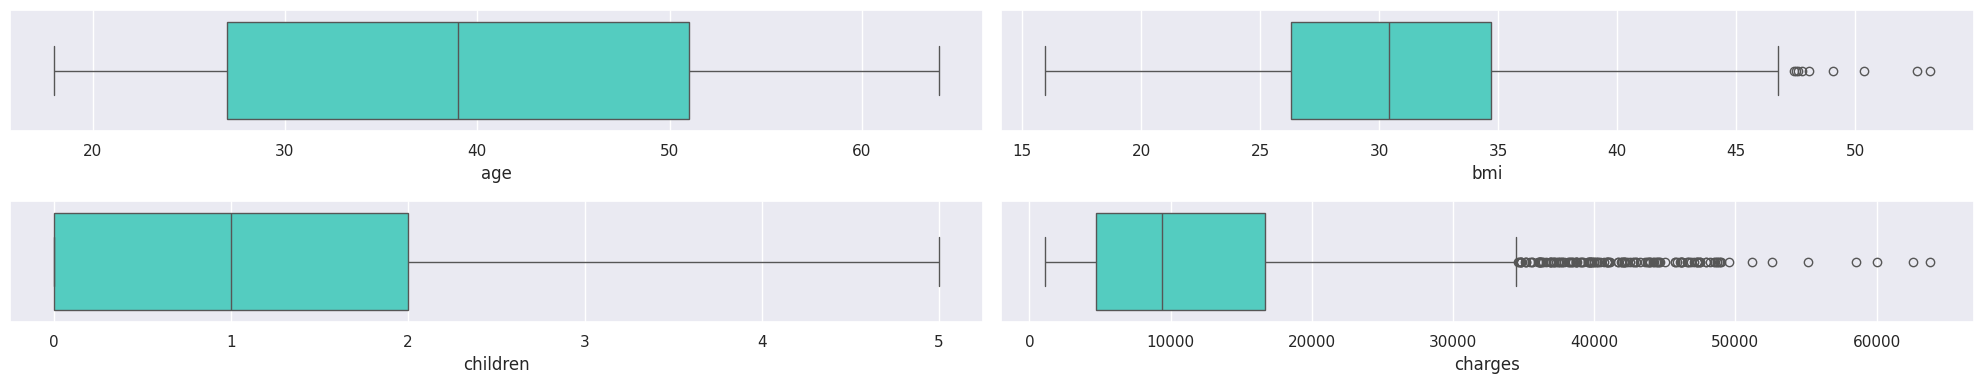

In [396]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise")
plt.tight_layout()
plt.show();

In [397]:
import matplotlib.pyplot as plt

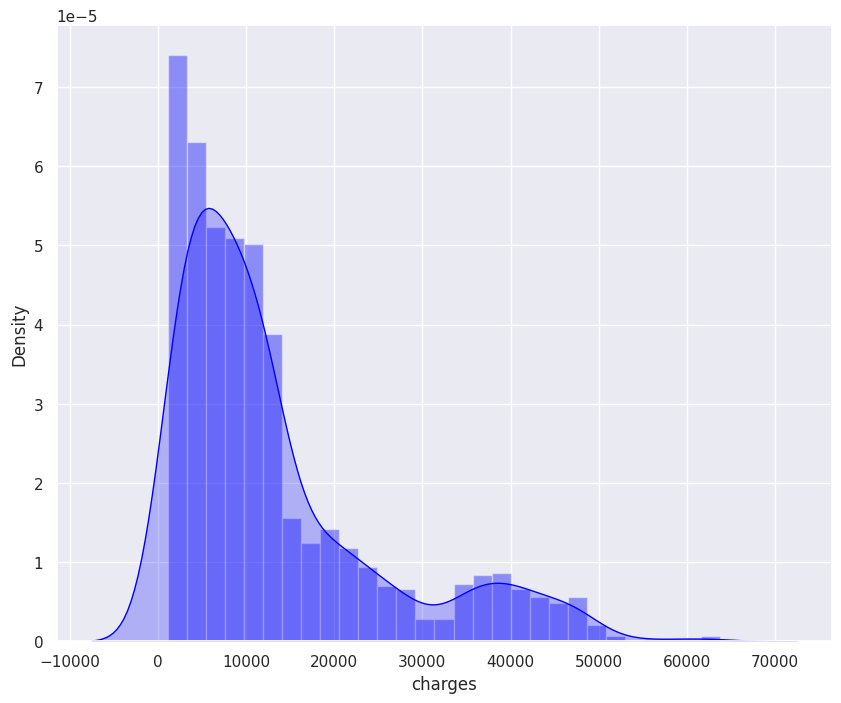

In [398]:
# I'm going to look at the distribution of variable charges
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df["charges"],
    color = "blue",
    kde_kws = {"shade": True, "linewidth": 1});
plt.savefig('distribución primas', dpi=300, bbox_inches='tight')


### Not normal

## We analyse the numerical variables of the dataset

### Distributions

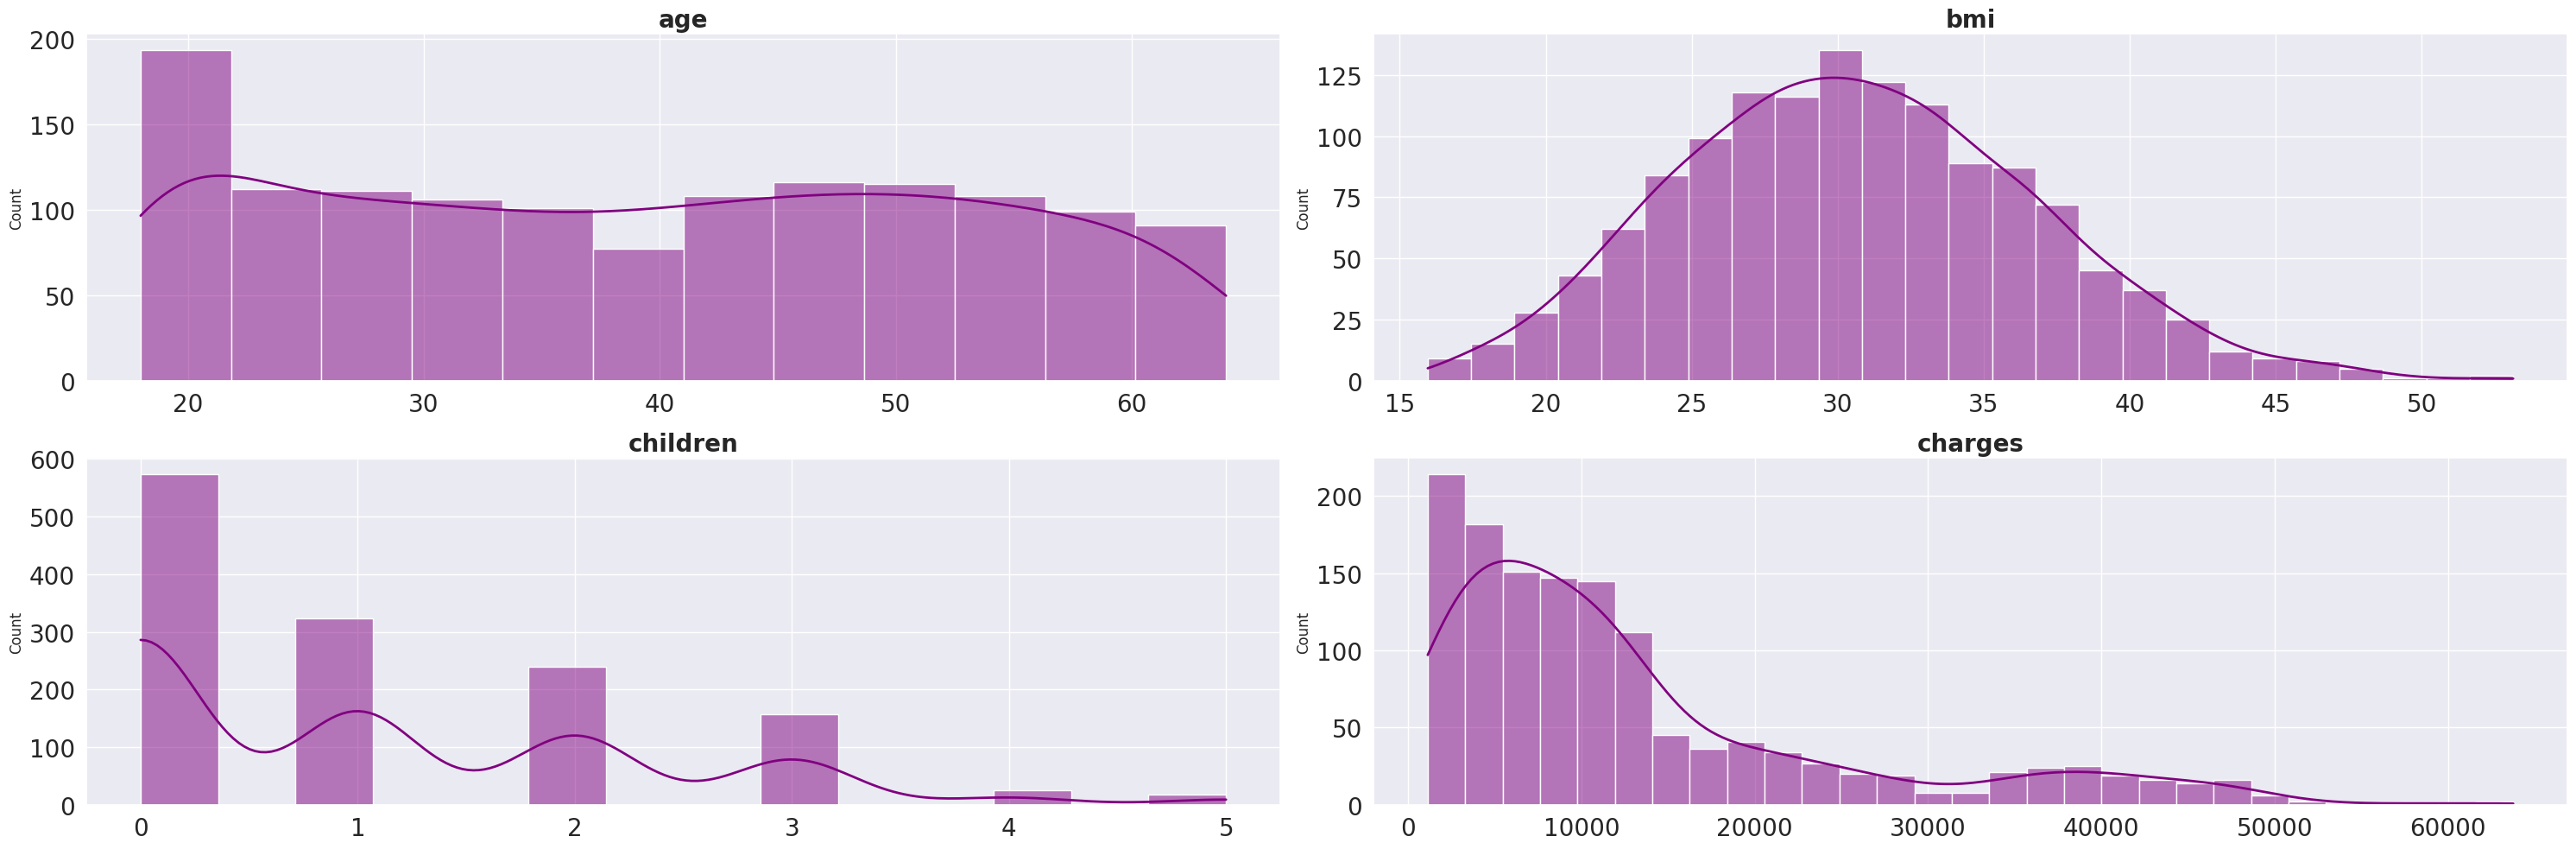

In [399]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterator
for i, colum in enumerate(numericas.columns):
    sns.histplot(
        data = numericas[colum],
        kde = True,
        color = "purple",
        line_kws = {"linewidth": 2},
        alpha = 0.5,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    plt.savefig('distrubuciones numéricas', dpi=300, bbox_inches='tight')
fig.tight_layout();

### Relationship to the response variable

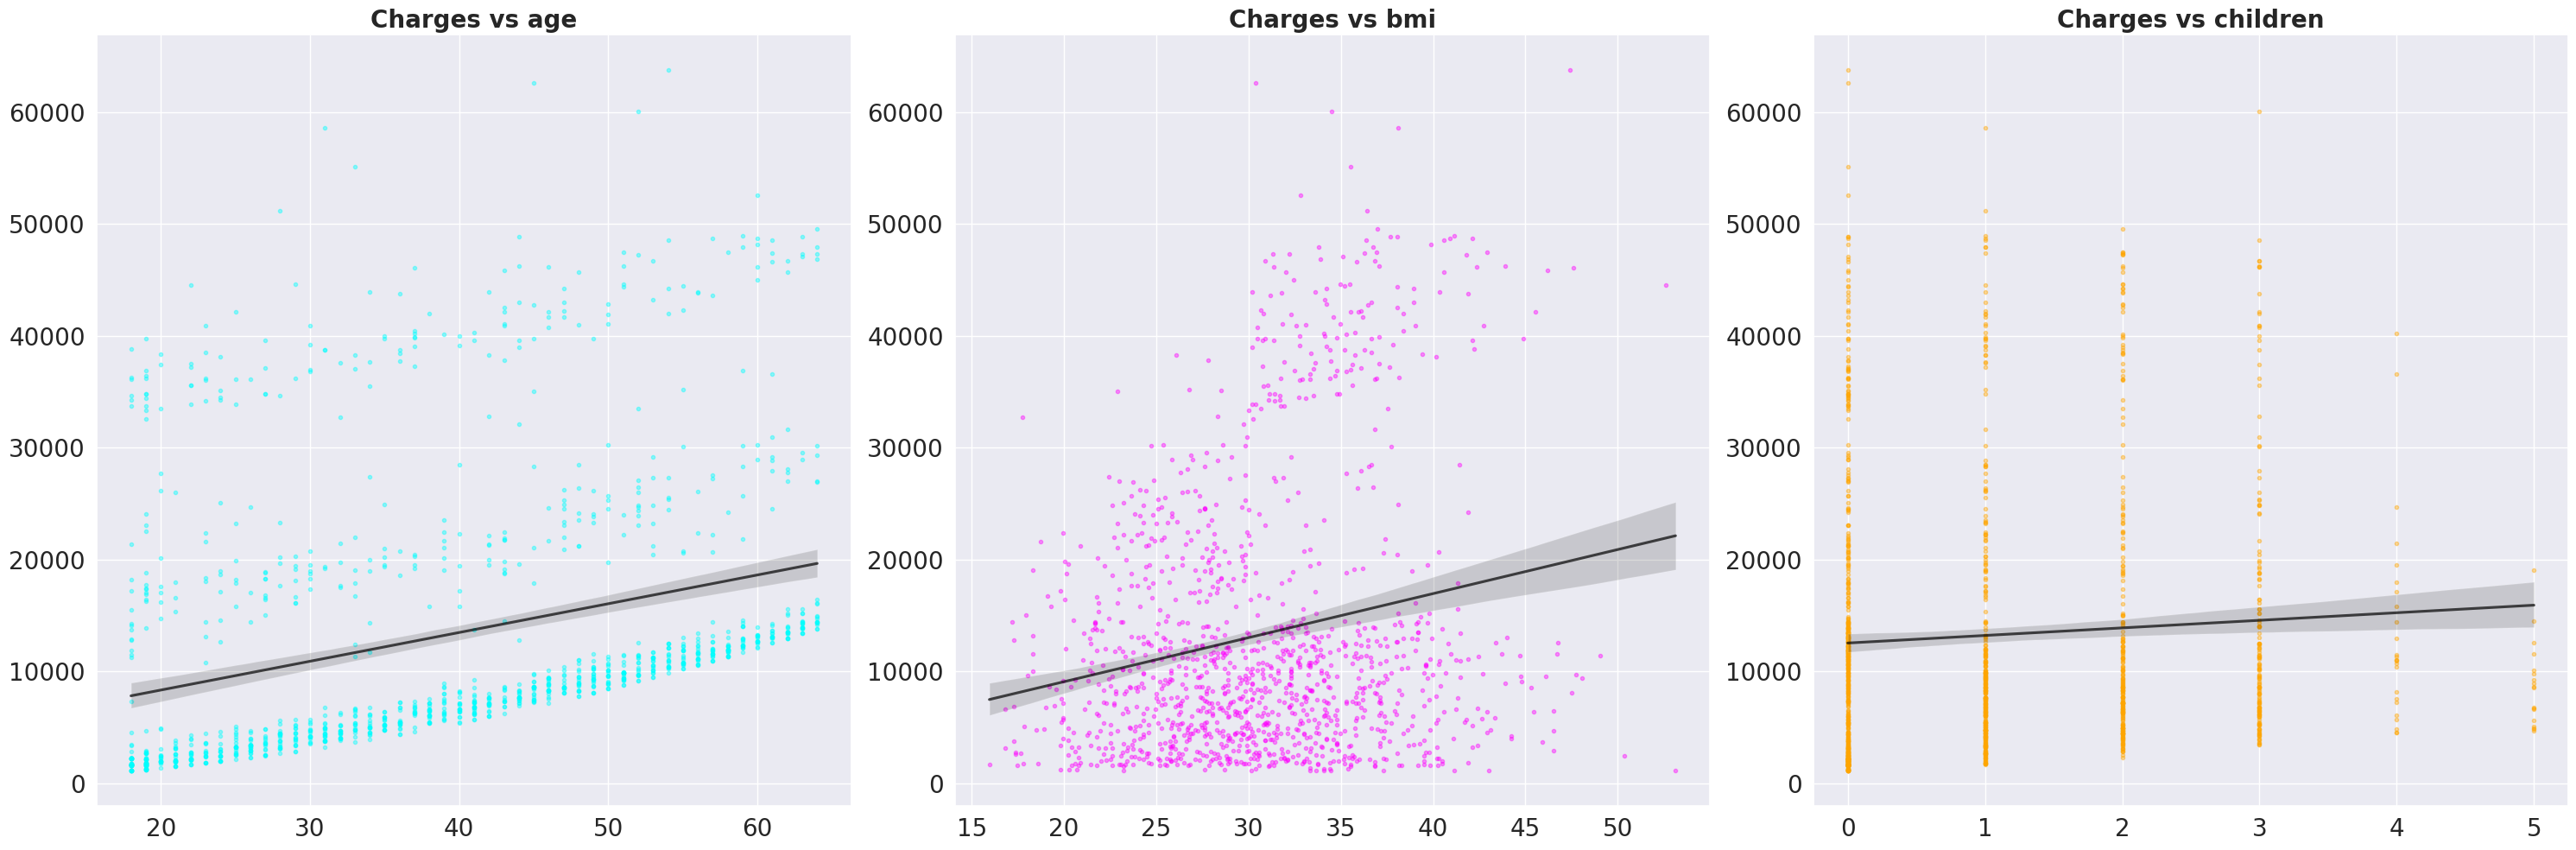

In [400]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
lista_colores = ["cyan", "magenta", "orange"]

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum],
        y = df["charges"],
        color = lista_colores[i],
        marker = ".",
        scatter_kws = {"alpha": 0.4},
        line_kws = {"color": "black", "alpha": 0.7 },
        ax = axes[i])

    axes[i].set_title(f"Charges vs {colum}", fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.tight_layout();


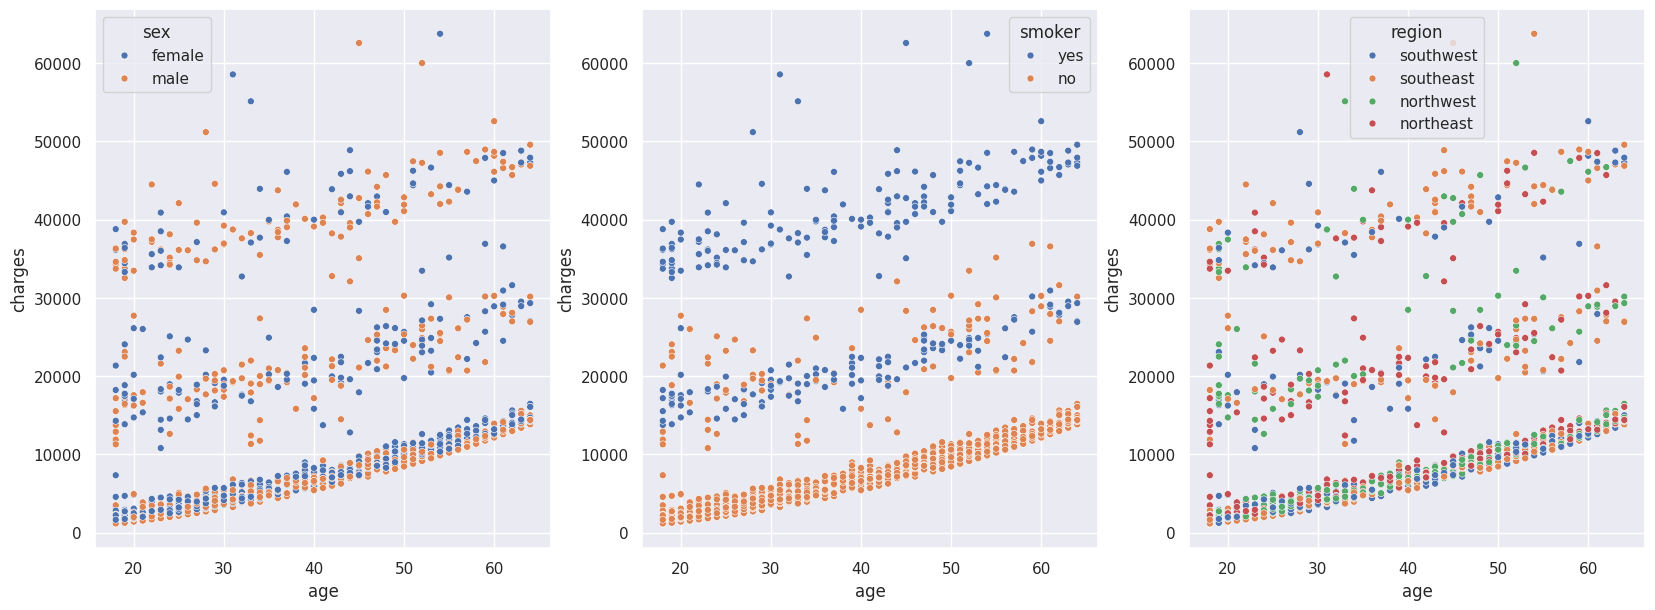

In [401]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df.select_dtypes(include='object')
for i in range(len(categoricas.columns)):
    sns.scatterplot(x='age', y='charges', data = df,
                    s = 25,
                    hue = categoricas.columns[i],
                    ax=axes[i])
plt.show();

Here we see that in age, there are about three clear trend lines in the distribution of our data.  
**-------------------------------------All 3 increase with age and tobacco-------------------------------------**

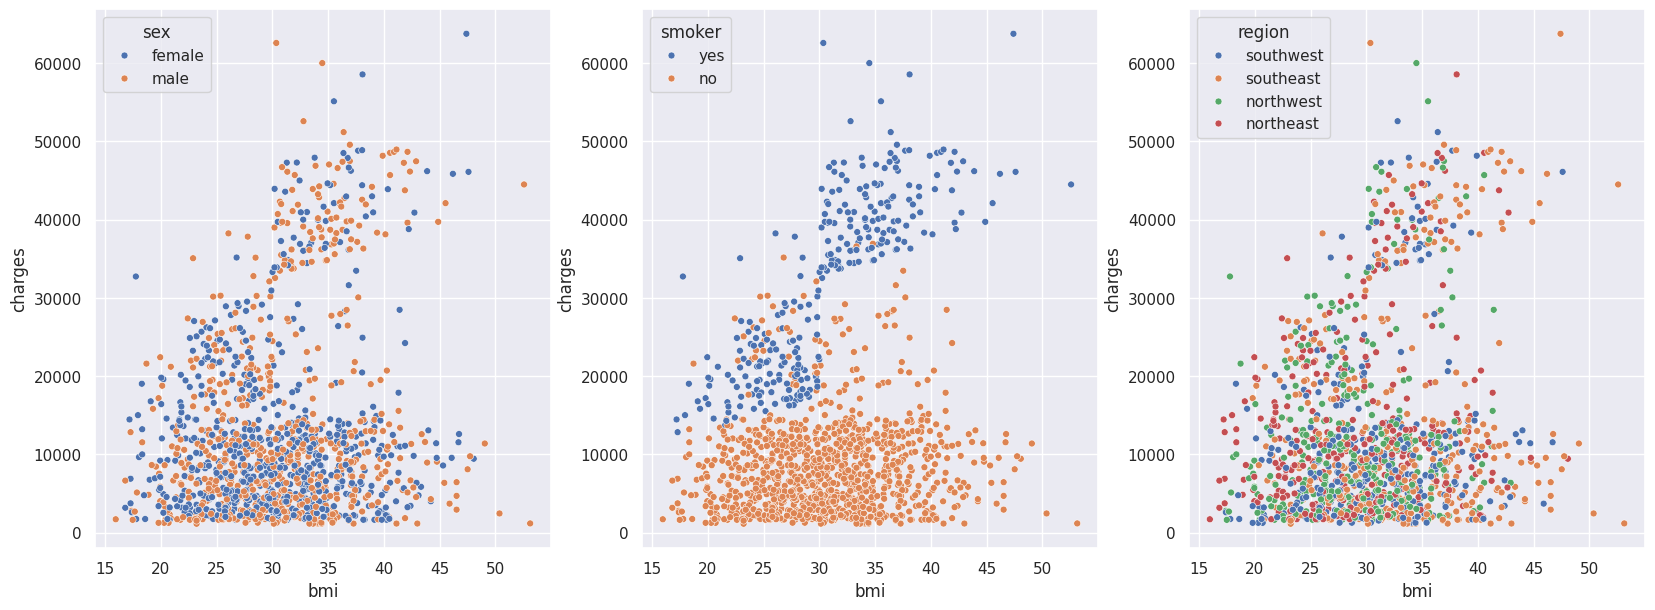

In [402]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))

for i in range(len(categoricas.columns)):
    sns.scatterplot(x='bmi', y='charges', data = df,
                    s = 25,
                    hue = categoricas.columns[i],
                    ax=axes[i])
plt.show();

**-------------------------------We see that there is a clear increase  in charges with tobacco--------------------------**

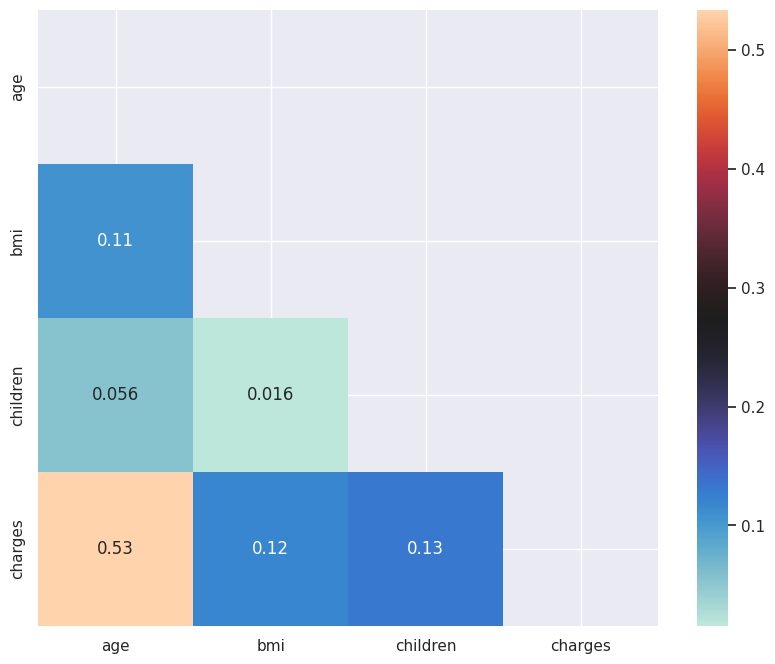

In [403]:
# Select only numeric columns for correlation calculation
df_numeric = df.select_dtypes(include=np.number)

mask = np.triu(np.ones_like(df_numeric.corr(method='spearman'), dtype = np.bool))
sns.heatmap(df_numeric.corr(method='spearman'),
           cmap = "icefire",
            mask = mask,
           annot = True);

## Categorical variables

### I create some graphs to go deeper into the data

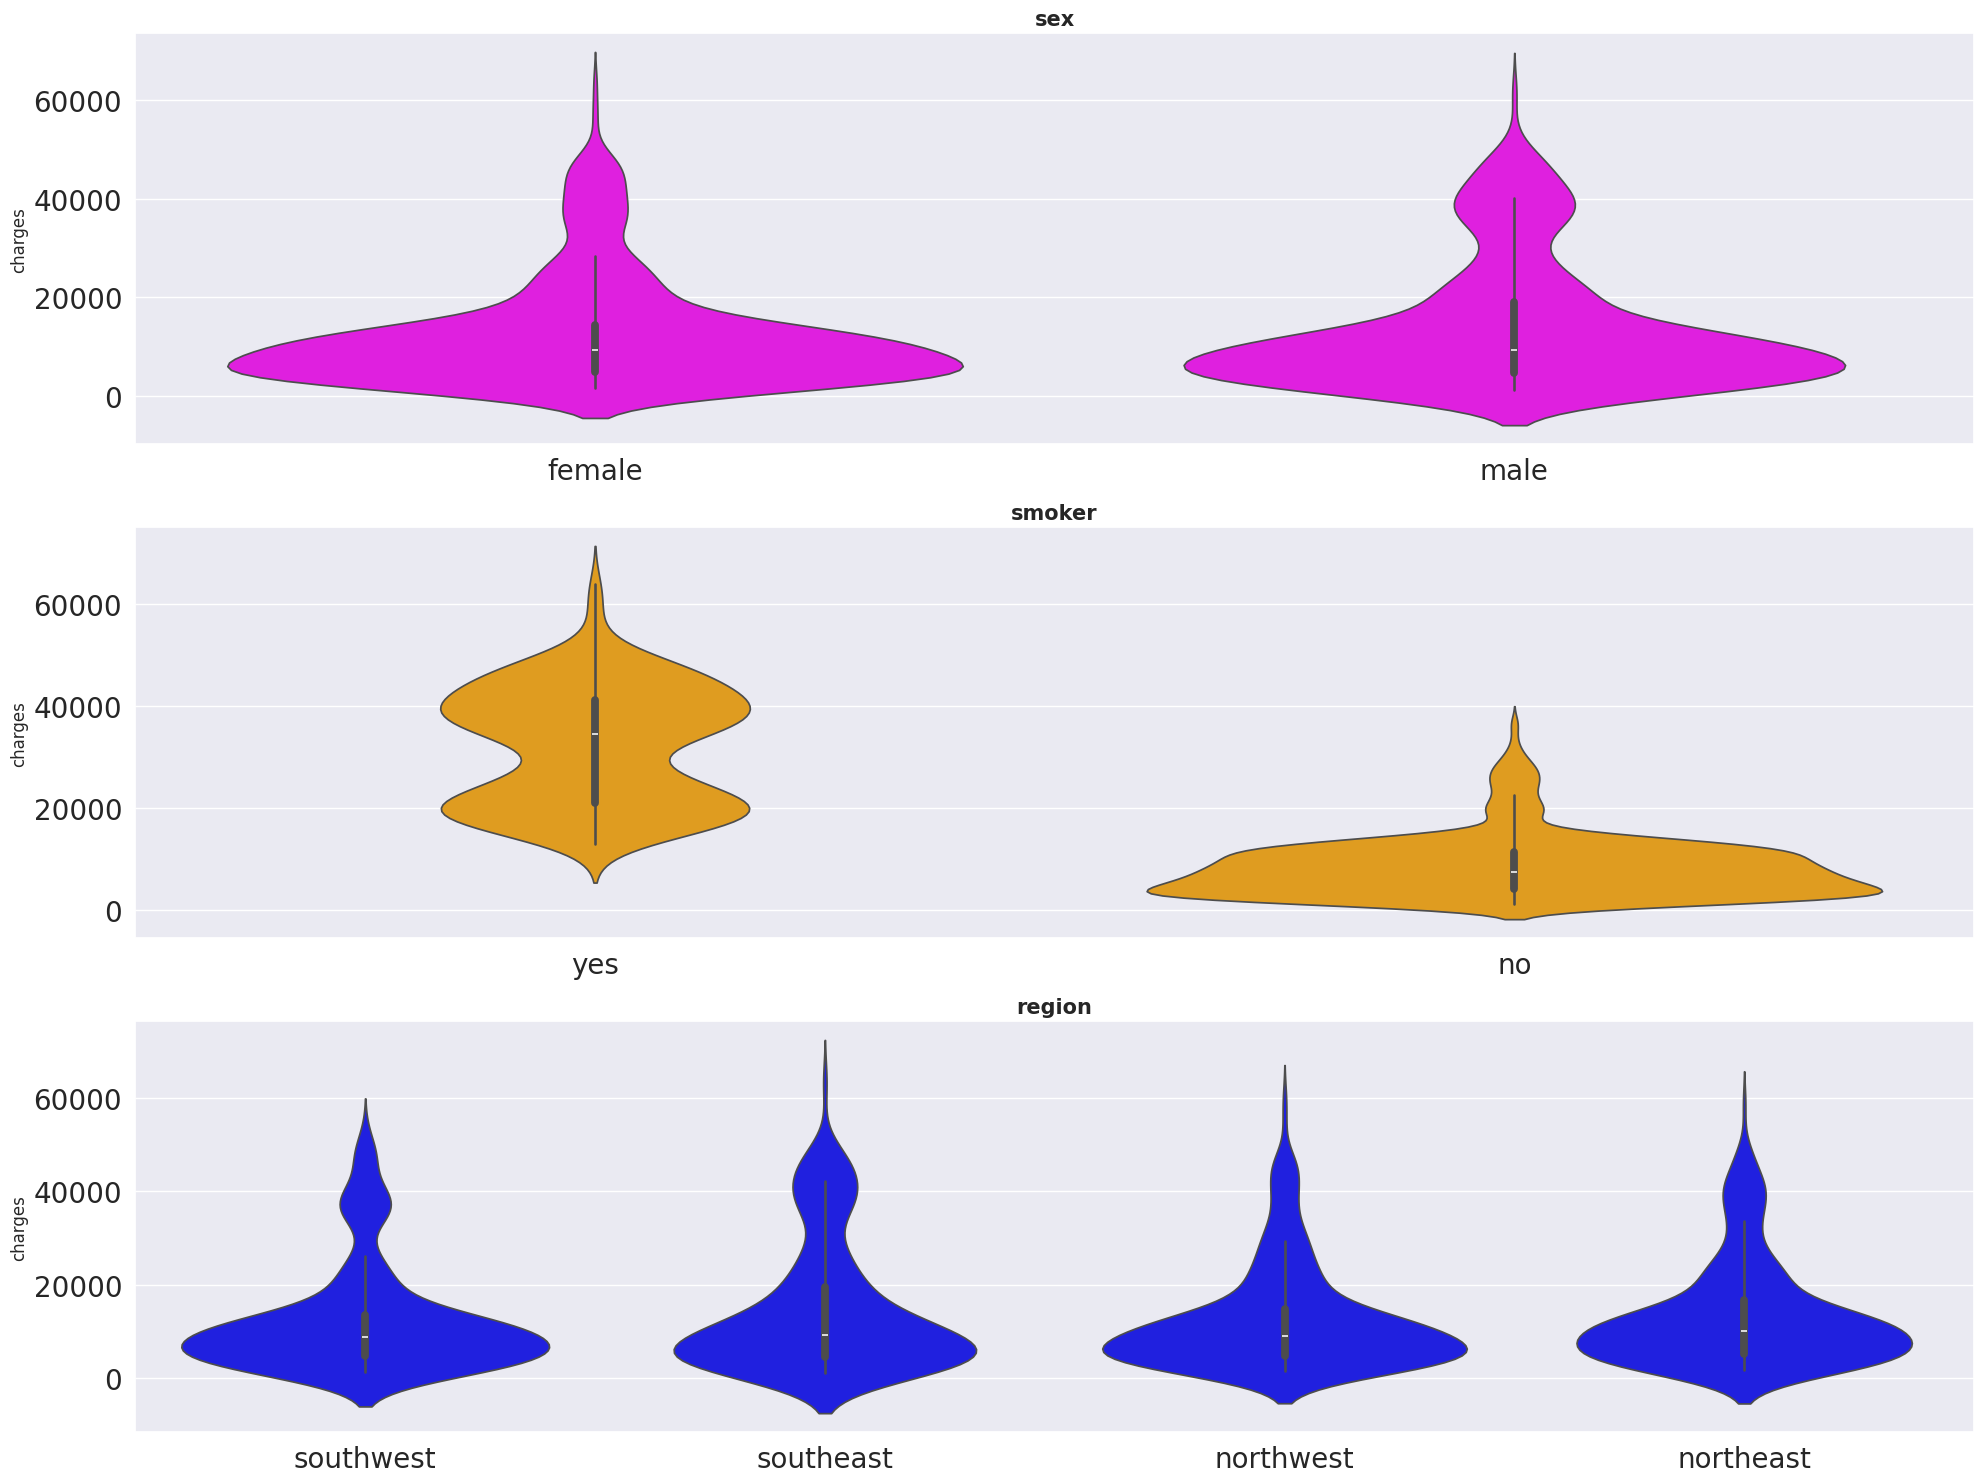

In [404]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
axes = axes.flat
lista_colores = [ "magenta", "orange","blue", "green"]
columnas = df.select_dtypes(include = 'object')
columnas = columnas.columns
for i, colum in enumerate(columnas):
    sns.violinplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout();

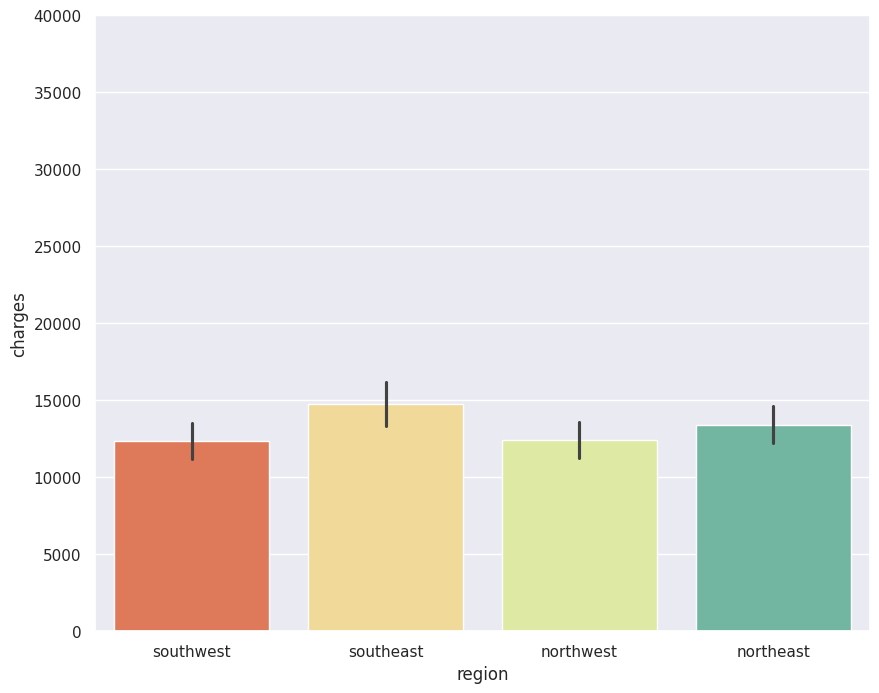

In [405]:
sns.barplot(x='region', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

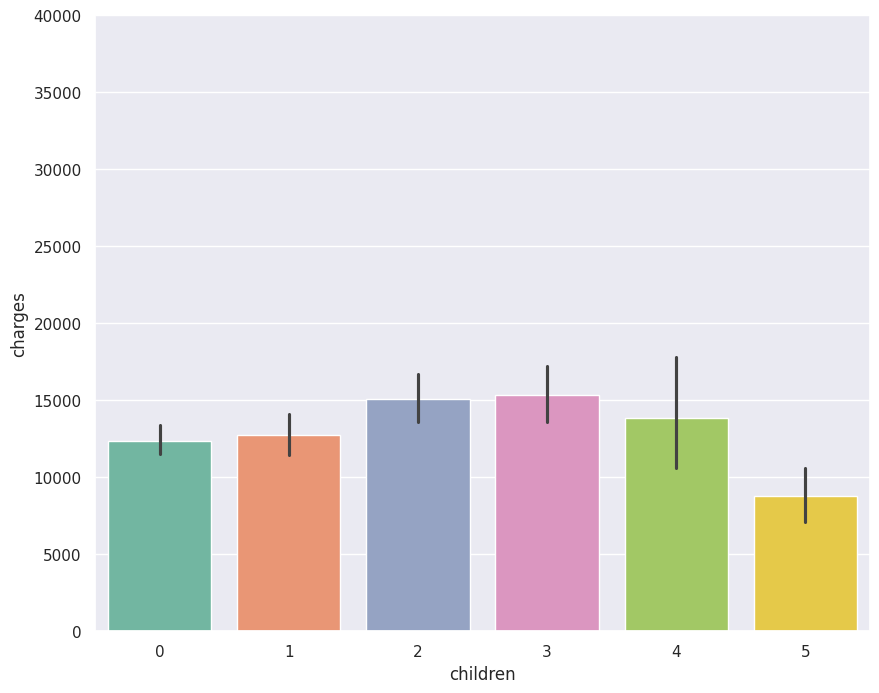

In [406]:
sns.barplot(x='children', y='charges', data=df, palette='Set2')
plt.ylim(0,40000);

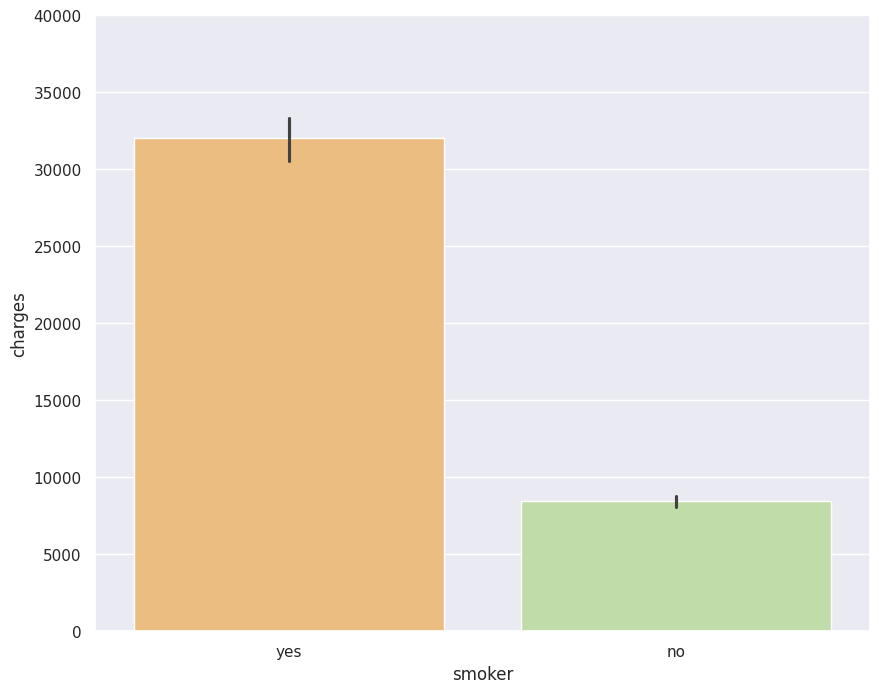

In [407]:
sns.barplot(x='smoker', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

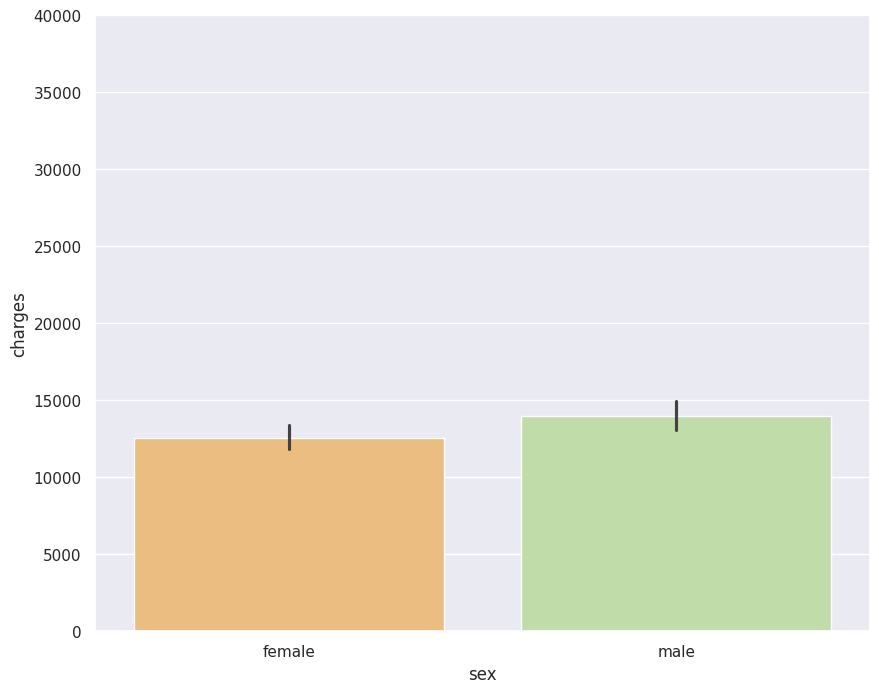

In [408]:
sns.barplot(x='sex', y='charges' ,data=df, palette='Spectral')
plt.ylim(0,40000);

modelo

In [409]:
df['sex'] = df['sex'].map({'female':0,'male':1})
df['smoker'] = df['smoker'].map({'no':0,'yes':1})
df['region'] = df['region'].map({'northeast':1,'northwest':2,'southeast':3,'southwest':4})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,4,16884.92
1,18,1,33.77,1,0,3,1725.55
2,28,1,33.00,3,0,3,4449.46
3,33,1,22.70,0,0,2,21984.47
4,32,1,28.88,0,0,2,3866.86


In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int64  
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   int64  
 5   region    1337 non-null   int64  
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 83.6 KB


In [411]:
X = df.drop('charges',axis=1)
y = df['charges']

In [412]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [413]:
from lazypredict.Supervised import LazyRegressor

In [414]:
clf = LazyRegressor(verbose=0)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 6
[LightGBM] [Info] Start training from score 13030.203373


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.90,0.90,4262.66,0.28
HistGradientBoostingRegressor,0.89,0.89,4513.08,0.35
LGBMRegressor,0.88,0.89,4548.47,0.08
BaggingRegressor,0.88,0.88,4620.42,0.11
RandomForestRegressor,0.88,0.88,4664.23,0.49
XGBRegressor,0.86,0.87,4932.71,0.18
KNeighborsRegressor,0.86,0.86,4989.34,0.05
ExtraTreesRegressor,0.85,0.85,5273.32,0.52
PoissonRegressor,0.83,0.83,5511.73,0.02


In [415]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

In [416]:
# iniciamos la regresión lineal

lr = LinearRegression(n_jobs=-1)

In [417]:
# fitear el modelo

lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [418]:
# predicciones

y_predict_train = lr.predict(x_train)
y_predict_test = lr.predict(x_test)

In [419]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_predict_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test)})
resultados = pd.concat([train_df,test_df], axis = 0)
resultados.head()

,Real,Predicted,Set
1114,2396.10,2236.24,Train
968,3279.87,3193.03,Train
599,33471.97,14449.32,Train
170,13405.39,17013.40,Train
275,9715.84,10027.87,Train


In [420]:
resultados['residuos'] = resultados['Real'] - resultados['Predicted']
resultados.head()

,Real,Predicted,Set,residuos
1114,2396.10,2236.24,Train,159.86
968,3279.87,3193.03,Train,86.84
599,33471.97,14449.32,Train,19022.66
170,13405.39,17013.40,Train,-3608.01
275,9715.84,10027.87,Train,-312.03


In [421]:
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test),'MAE': mean_absolute_error(y_test, y_predict_test),'MSE': mean_squared_error(y_test, y_predict_test),'RMSE': np.sqrt(mean_squared_error(y_test, y_predict_test)),'R2':  r2_score(y_test, y_predict_test),"modelo": "LinearRegression"})

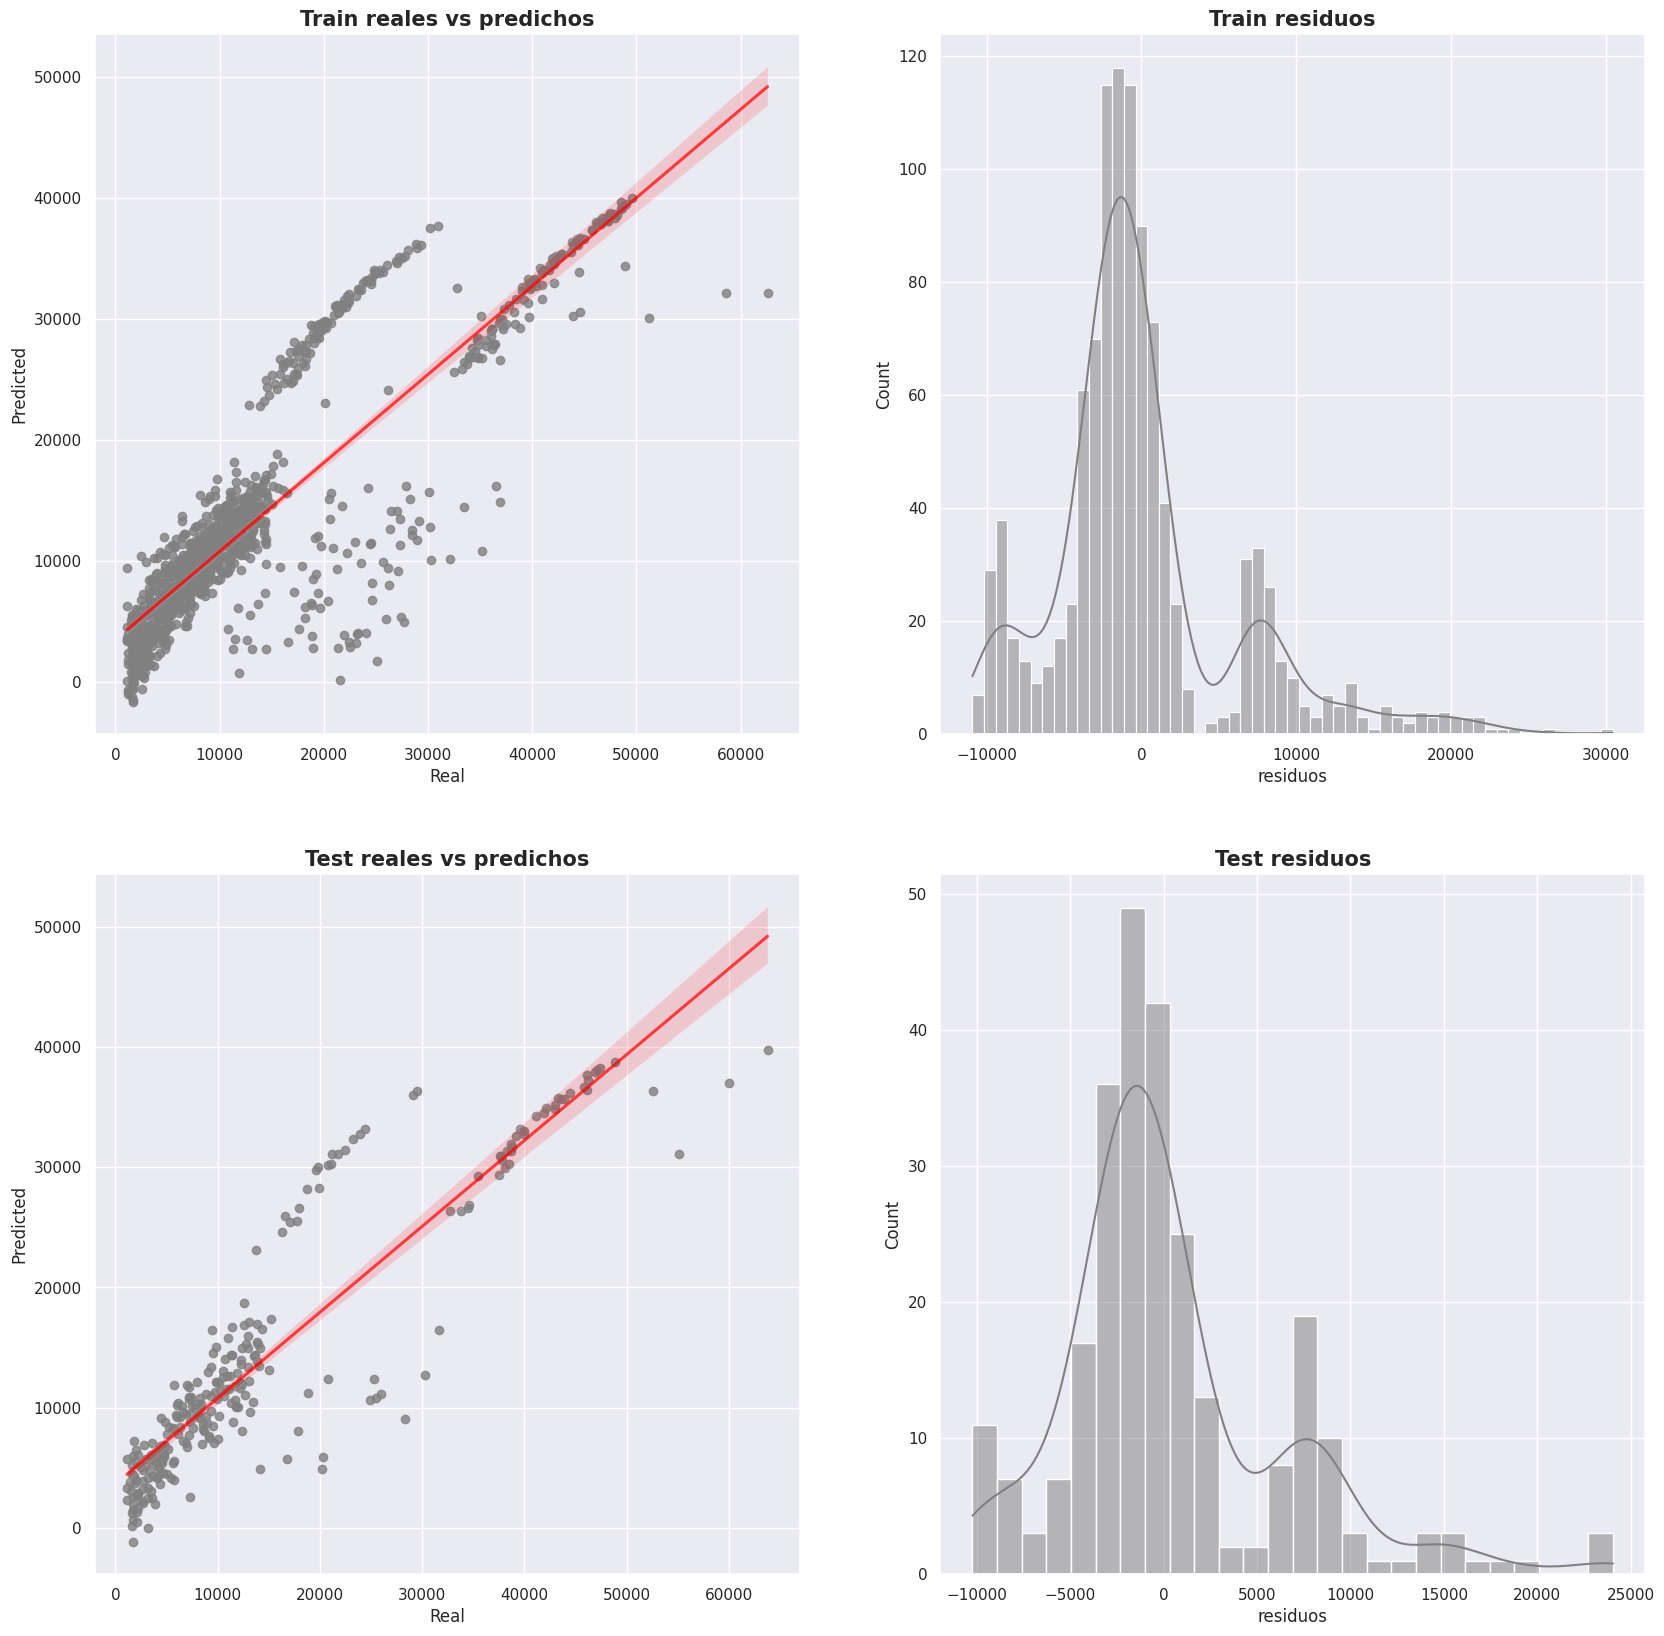

In [422]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = resultados[resultados['Set'] == "Train"],
            x = "Real",
            y = "Predicted",
            ax = ax[0,0],
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = resultados[resultados['Set'] == "Test"],
            x = "Real",
            y = "Predicted",
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 },
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(resultados[resultados['Set'] == "Train"],
             x="residuos",
             color ="grey",
             kde=True,
             ax = ax[0,1])


sns.histplot(resultados[resultados['Set'] == "Test"],
             x="residuos",
             color = "grey",
             kde=True,
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");


In [423]:
resultados_metricas = {'MAE': [mean_absolute_error(y_test, y_predict_test), mean_absolute_error(y_train, y_predict_train)],
                'MSE': [mean_squared_error(y_test, y_predict_test), mean_squared_error(y_train, y_predict_train)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_predict_test)), np.sqrt(mean_squared_error(y_train, y_predict_train))],
                'R2':  [r2_score(y_test, y_predict_test), r2_score(y_train, y_predict_train)],
                 "set": ["test", "train"],
                 "modelo": ["Linear Regresion", "LinearRegression"]}

df_resultados = pd.DataFrame(resultados_metricas)

df_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,4182.35,35493102.61,5957.61,0.81,test,Linear Regresion
1,4181.32,37005531.73,6083.22,0.73,train,LinearRegression


In [424]:
from sklearn.preprocessing import StandardScaler

In [425]:
# Standardize the dataset
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [426]:
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'absolute_error'}

In [427]:
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(x_train_std, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          min_samples_split=5, n_estimators=1000)


IMPORTANCIA DE VARIABLES
age         :  44.7%
smoker      :  27.1%
children    :   8.2%
region      :   7.4%
bmi         :   6.7%
sex         :   5.9%


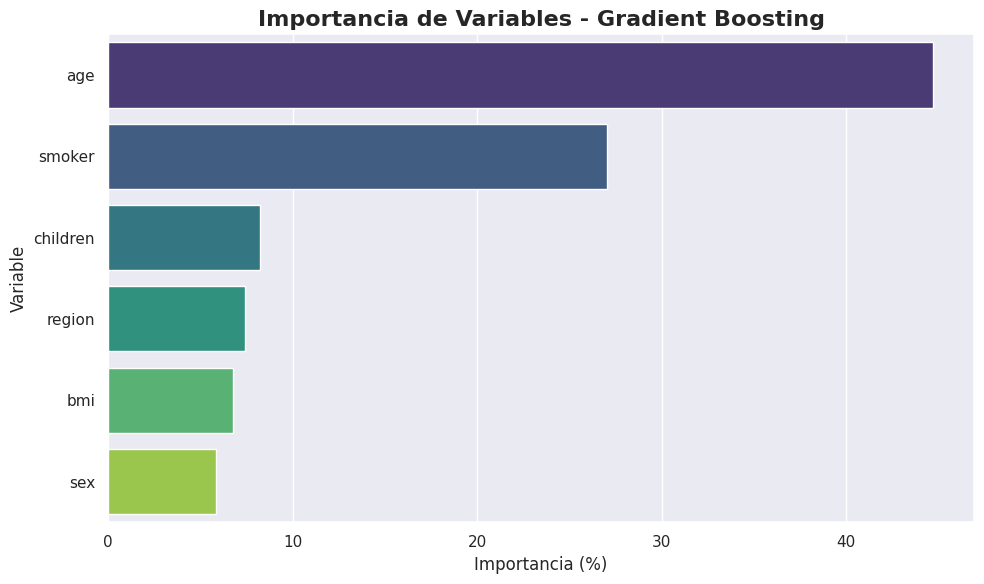

In [428]:
# Extraer importancia de variables
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': gbr.feature_importances_
}).sort_values('importance', ascending=False)

# Calcular porcentajes
feature_importance['percentage'] = (
    feature_importance['importance'] /
    feature_importance['importance'].sum() * 100
)

print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES")
print("="*60)
for _, row in feature_importance.iterrows():
    print(f"{row['feature']:12s}: {row['percentage']:5.1f}%")

# Visualizar y guardar
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='percentage', y='feature', palette='viridis')
plt.title('Importancia de Variables - Gradient Boosting', fontsize=16, fontweight='bold')
plt.xlabel('Importancia (%)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [429]:
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(x_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(x_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
#
rmse= np.sqrt(mean_squared_error(y_test, gbr.predict(x_test_std)))

Model Accuracy: 0.829
The mean squared error (MSE) on test set: 31364668.7758


Smokers

In [430]:
dffum = df[(df['smoker'] == 1)]
dffum

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,4,16884.92
11,62,0,26.29,0,1,3,27808.73
14,27,1,42.13,0,1,3,39611.76
19,30,1,35.30,0,1,4,36837.47
23,34,0,31.92,1,1,1,37701.88
...,...,...,...,...,...,...,...
1313,19,0,34.70,2,1,4,36397.58
1314,30,0,23.66,3,1,2,18765.88
1321,62,1,26.70,0,1,1,28101.33
1323,42,0,40.37,2,1,3,43896.38


In [431]:
X_fum = dffum.drop('charges',axis=1)
y_fum= dffum['charges']

In [432]:
from sklearn.model_selection import train_test_split
X_train_fum, X_test_fum, y_train_fum, y_test_fum = train_test_split( X_fum, y_fum, test_size=0.2, random_state=42)
X_train_fum.shape, X_test_fum.shape

((219, 6), (55, 6))

In [433]:
clf_fum = LazyRegressor(verbose=0)
models_fum,predictions_fum = clf_fum.fit(X_train_fum, X_test_fum, y_train_fum, y_test_fum)
models_fum

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 5
[LightGBM] [Info] Start training from score 31697.790793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
BaggingRegressor,0.87,0.89,4133.33,0.05
RandomForestRegressor,0.87,0.89,4149.35,0.33
XGBRegressor,0.86,0.88,4277.95,0.20
GradientBoostingRegressor,0.86,0.88,4298.51,0.13
HistGradientBoostingRegressor,0.86,0.87,4342.74,0.08
ExtraTreesRegressor,0.85,0.86,4512.81,0.15
LGBMRegressor,0.84,0.86,4553.20,0.06
DecisionTreeRegressor,0.79,0.81,5299.05,0.01
AdaBoostRegressor,0.77,0.79,5593.13,0.13


Non Smokers

In [434]:
dfnfum = df[(df['smoker'] == 0)]
dfnfum.sample(5)

,age,sex,bmi,children,smoker,region,charges
1254,34,0,27.72,0,0,3,4415.16
1080,18,1,21.78,2,0,3,11884.05
429,27,0,30.40,3,0,2,18804.75
683,53,1,24.32,0,0,2,9863.47
1032,30,0,27.93,0,0,1,4137.52


In [435]:
X_nfum = dfnfum.drop('charges',axis=1)
y_nfum= dfnfum['charges']

In [436]:
from sklearn.model_selection import train_test_split
X_train_nfum, X_test_nfum, y_train_nfum, y_test_nfum = train_test_split( X_nfum, y_nfum, test_size=0.2, random_state=42)
X_train_nfum.shape, X_test_nfum.shape

((850, 6), (213, 6))

In [437]:
clf_nfum = LazyRegressor(verbose=0)
models_nfum,predictions_nfum = clf_nfum.fit(X_train_nfum, X_test_nfum, y_train_nfum, y_test_nfum)
models_nfum

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 5
[LightGBM] [Info] Start training from score 8460.615950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoCV,0.38,0.40,4712.83,0.09
Lasso,0.38,0.40,4712.91,0.02
LassoLars,0.38,0.40,4712.91,0.02
LinearRegression,0.38,0.40,4712.93,0.01
TransformedTargetRegressor,0.38,0.40,4712.93,0.02
Lars,0.38,0.40,4712.93,0.02
LarsCV,0.38,0.40,4712.93,0.03
LassoLarsIC,0.38,0.40,4712.93,0.02
LassoLarsCV,0.38,0.40,4712.93,0.02


Healthy BMI

In [438]:
df_bmi_ok = df[(df['bmi']<=25)]
df_bmi_ok.sample(5)

,age,sex,bmi,children,smoker,region,charges
756,39,0,22.80,3,0,1,7985.81
1045,43,0,24.70,2,1,2,21880.82
681,19,1,20.30,0,0,4,1242.26
1316,19,0,20.60,0,0,4,1731.68
224,42,1,24.64,0,1,3,19515.54


In [439]:
X_bmi_ok = df_bmi_ok.drop('charges',axis=1)
y_bmi_ok= df_bmi_ok['charges']

In [440]:
from sklearn.model_selection import train_test_split
X_train_bmi_ok, X_test_bmi_ok, y_train_bmi_ok, y_test_bmi_ok = train_test_split( X_bmi_ok, y_bmi_ok, test_size=0.2, random_state=42)
X_train_bmi_ok.shape, X_test_bmi_ok.shape

((197, 6), (50, 6))

In [441]:
clf_bmi_ok = LazyRegressor(verbose=0)
models_bmi_ok,predictions_bmi_ok = clf_bmi_ok.fit(X_train_bmi_ok, X_test_bmi_ok, y_train_bmi_ok, y_test_bmi_ok)
models_bmi_ok

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 6
[LightGBM] [Info] Start training from score 10168.166463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
OrthogonalMatchingPursuitCV,0.46,0.52,5647.76,0.02
LassoCV,0.45,0.52,5656.07,0.09
SGDRegressor,0.45,0.52,5656.14,0.02
Lasso,0.45,0.52,5657.30,0.03
LassoLars,0.45,0.52,5657.31,0.01
LarsCV,0.45,0.52,5657.61,0.03
Lars,0.45,0.52,5657.61,0.02
LassoLarsCV,0.45,0.52,5657.61,0.03
TransformedTargetRegressor,0.45,0.52,5657.61,0.01


Unhealthy BMI

In [442]:
df = pd.read_csv("00-insurance.csv", index_col = 0).reset_index()
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55


In [443]:
df.drop_duplicates(inplace=True)

In [444]:
df['sex'] = df['sex'].map({'female':0,'male':1})
df['smoker'] = df['smoker'].map({'no':0,'yes':1})
df['region'] = df['region'].map({'northeast':3,'northwest':1,'southeast':4,'southwest':2})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,2,16884.92
1,18,1,33.77,1,0,4,1725.55
2,28,1,33.00,3,0,4,4449.46
3,33,1,22.70,0,0,1,21984.47
4,32,1,28.88,0,0,1,3866.86


In [445]:
df_bmi_nok = df[(df['bmi'] >25)]
df_bmi_nok.sample(5)

,age,sex,bmi,children,smoker,region,charges
125,26,0,28.79,0,0,3,3385.40
398,64,1,25.60,2,0,2,14988.43
673,41,0,31.02,0,0,4,6185.32
525,18,0,33.88,0,0,4,11482.63
618,19,0,33.11,0,1,4,34439.86


In [446]:
X_bmi_nok = df_bmi_nok.drop('charges',axis=1)
y_bmi_nok= df_bmi_nok['charges']

In [447]:
from sklearn.model_selection import train_test_split
X_train_bmi_nok, X_test_bmi_nok, y_train_bmi_nok, y_test_bmi_nok = train_test_split( X_bmi_nok, y_bmi_nok, test_size=0.2, random_state=42)
X_train_bmi_nok.shape, X_test_bmi_nok.shape

((872, 6), (218, 6))

In [448]:
clf_bmi_nok = LazyRegressor(verbose=0)
models_bmi_nok,predictions_bmi_nok = clf_bmi_nok.fit(X_train_bmi_nok, X_test_bmi_nok, y_train_bmi_nok, y_test_bmi_nok)
models_bmi_nok

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 6
[LightGBM] [Info] Start training from score 13907.125473


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.87,0.87,4731.65,0.20
RandomForestRegressor,0.87,0.87,4822.71,0.44
LGBMRegressor,0.86,0.87,4844.33,0.06
HistGradientBoostingRegressor,0.86,0.86,4926.46,0.21
ExtraTreesRegressor,0.85,0.85,5115.81,0.31
BaggingRegressor,0.85,0.85,5136.80,0.07
AdaBoostRegressor,0.84,0.85,5253.14,0.07
XGBRegressor,0.84,0.84,5279.82,0.18
KNeighborsRegressor,0.83,0.83,5458.06,0.03


In [449]:
print("\n" + "="*70)
print("VALIDACIÓN DE PROPUESTA DE NEGOCIO")
print("="*70)

# Ejemplo del HTML: Cliente 40 años, BMI 32 → BMI 24
ejemplo_antes = pd.DataFrame({
    'age': [40],
    'sex': [1],  # male
    'bmi': [32],
    'children': [0],
    'smoker': [0],  # no fumador
    'region': [4]  # southwest
})

ejemplo_despues = ejemplo_antes.copy()
ejemplo_despues['bmi'] = 24

# Estandarizar (usando el mismo scaler del modelo)
ejemplo_antes_std = sc.transform(ejemplo_antes)
ejemplo_despues_std = sc.transform(ejemplo_despues)

# Predecir
pred_antes = gbr.predict(ejemplo_antes_std)[0]
pred_despues = gbr.predict(ejemplo_despues_std)[0]
ahorro = pred_antes - pred_despues
reduccion_porcentaje = (ahorro / pred_antes) * 100

# Ejemplo del HTML: Cliente 40 años, BMI 32 → BMI 24
ejemplo_antes2 = pd.DataFrame({
    'age': [40],
    'sex': [1],  # male
    'bmi': [32],
    'children': [0],
    'smoker': [1],  # no fumador
    'region': [4]  # southwest
})

ejemplo_despues2 = ejemplo_antes2.copy()
ejemplo_despues2['bmi'] = 24

# Estandarizar (usando el mismo scaler del modelo)
ejemplo_antes_std2 = sc.transform(ejemplo_antes2)
ejemplo_despues_std2 = sc.transform(ejemplo_despues2)

# Predecir
pred_antes2 = gbr.predict(ejemplo_antes_std2)[0]
pred_despues2 = gbr.predict(ejemplo_despues_std2)[0]
ahorro2 = pred_antes2 - pred_despues2
reduccion_porcentaje2 = (ahorro2 / pred_antes2) * 100

print(f"\nEjemplo: Cliente 40 años, fumador")
print(f"Prima con BMI 32: ${pred_antes2:,.2f}")
print(f"Prima con BMI 24: ${pred_despues:,.2f}")
print(f"Ahorro anual: ${ahorro2:,.2f}")
print(f"Reducción: {reduccion_porcentaje2:.1f}%")
print(f"\nPropuesta HTML: 25% de reducción")

print(f"\nEjemplo: Cliente 40 años, no fumador")
print(f"Prima con BMI 32: ${pred_antes:,.2f}")
print(f"Prima con BMI 24: ${pred_despues:,.2f}")
print(f"Ahorro anual: ${ahorro:,.2f}")
print(f"Reducción: {reduccion_porcentaje:.1f}%")
print(f"\nPropuesta HTML: 25% de reducción")

if abs(reduccion_porcentaje - 25) < 5:
    print("La propuesta es realista y validada")
else:
    print(f"Considerar ajustar propuesta a ~{reduccion_porcentaje:.0f}%")


VALIDACIÓN DE PROPUESTA DE NEGOCIO

Ejemplo: Cliente 40 años, fumador
Prima con BMI 32: $37,685.71
Prima con BMI 24: $5,784.77
Ahorro anual: $14,381.60
Reducción: 38.2%

Propuesta HTML: 25% de reducción

Ejemplo: Cliente 40 años, no fumador
Prima con BMI 32: $5,801.26
Prima con BMI 24: $5,784.77
Ahorro anual: $16.48
Reducción: 0.3%

Propuesta HTML: 25% de reducción
Considerar ajustar propuesta a ~0%


In [450]:
import nbformat

# Asegúrate de que la ruta sea la correcta para tu notebook
notebook_path = "/content/02-resume_model.ipynb"

# Leer el notebook
try:
    nb = nbformat.read(notebook_path, as_version=4)

    # Borrar la metadata a nivel de notebook (aquí es donde vive 'widgets')
    if 'widgets' in nb.metadata:
        del nb.metadata['widgets']

    # Opcional pero recomendado: Limpiar también los outputs y metadatos de las celdas
    for cell in nb.cells:
        if 'outputs' in cell:
            cell['outputs'] = []
        cell.metadata = {}

    # Guardar el notebook ya limpio
    nbformat.write(nb, notebook_path)

    print("✅ Notebook limpio y listo para subir a GitHub.")

except Exception as e:
    print(f"Ocurrió un error: {e}")


✅ Notebook limpio y listo para subir a GitHub.


## Best metrics are given by GradientBooster, our response variable does not have a normal distribution, nor is the relationship with the response variables entirely linear. We could fit the model with interval prediction.